In [1]:
ENV["LIBTENSORFLOW"]="/usr/local/cuda-8.0/targets/x86_64-linux/lib/libtensorflow"
using TensorFlow
using CSV: read
using Distributions: Normal
using ProgressMeter: @showprogress
using PyPlot: plot,figure, axvline, axhline, xlim, ylim, title, xlabel, ylabel

In [2]:
type layer
    _in   ::Int64
    _out  ::Int64
    
    W     ::Any
    Wt    ::Any
    be    ::Any
    bd    ::Any
    
    opt   ::Any
    loss  ::Any
end

layer() = layer(0,0,0,0,0,0,0,0)

type AE
    l1    ::Any
    l2    ::Any
    
    sess  ::Any
    lvec  ::Any
    dist  ::Any
    saver ::Any
end

AE() = AE(layer(),layer(),0,0,0,0)

AE

In [3]:
# Reading the data
f = read("/home/ringo/Desktop/labeled_segments/dir_Light_Rail_1464134398767000000_1464136341648000000/accel.csv")

# definition of some commonly used values
T = Int64(floor(length(f[:,1])))       # number of data points per input channel
Nw = 20                                # window size
input_col = 1:1                        # columns of the CSV to read
Nc = length(input_col)                 # number of input channels
Ncw = Nc * Nw                          # input size
TNw = Int64(floor(T/Nw))               # number of time stamps

# create the synthetic square wave data to test on
x = linspace(1,T,T)
f = Array{Float64,2}(T,1)
f .= sign.(sin.(x/1000))+sin.(x/100)/10
println("success")

In [4]:
function data_init(ae)
    ae.l1._in = Ncw
    ae.l1._out = ae.l2._in = Int64(floor(ae.l1._in / 3))
    ae.l2._out = Int64(floor(ae.l2._in / 2))
    
    s = Array{Float64, 2}(Ncw,TNw)
    for i=1:TNw
        s[:,i] .= vec(convert(Array,f[Nw*(i-1)+1:Nw*i,input_col]))
    end
    return s
end

data_init (generic function with 1 method)

success


In [5]:
function weight_variable(shape, collec, λ=1e-2, reg=x->reduce_sum(reduce_sum(x^2,axis=1),axis=1))
    W = Variable(map(Float64, rand(Normal(0, .01), shape...)))
    # regularization term
    wd = λ * reg(W)
    TensorFlow.add_to_collection(collec, wd)
    return W
end

function bias_variable(shape)
    b = Variable(fill(Float64(.1), shape...))
    return b
end

function autoencoder(layer, input, collec)
    enc = nn.sigmoid(layer.W * input + layer.be)
    TensorFlow.add_to_collection(collec, enc)
    # return the latent vectors to be the input of the next layer and return the output to calculate the loss
    dec = nn.sigmoid(layer.Wt * enc + layer.bd)
    return enc, dec
end

autoencoder (generic function with 1 method)

In [6]:
function var_init(ae)
    ae.sess = Session(Graph())

    @tf begin
        ae.l1.W = weight_variable([ae.l1._out, ae.l1._in], :layer1_reg)
        ae.l1.be = bias_variable([ae.l1._out, 1])

        ae.l2.W = weight_variable([ae.l2._out, ae.l2._in], :layer2_reg)
        ae.l2.be = bias_variable([ae.l2._out, 1])

        # this is a tied weight
        ae.l2.Wt = transpose(ae.l2.W)
        ae.l2.bd = bias_variable([ae.l2._in, 1])

        # this is a tied weight too
        ae.l1.Wt = transpose(ae.l1.W)
        ae.l1.bd = bias_variable([ae.l1._in, 1])
    end
end

var_init (generic function with 1 method)

In [7]:
function build_net(ae, _data)
    # initialize input as a matrix; passing vectors does not work
    input = Array{Any, 2}(ae.l1._in,1)

    @tf begin
        data = constant(_data)

        # iterate over all time windows
        @showprogress for t=1:TNw
            # input is the t-th column of the data
            l1_input = slice(data,[1,t],[ae.l1._in,1])
            l2_input, l1_output = autoencoder(ae.l1, l1_input, :l1_latent_vectors)
            TensorFlow.add_to_collection(:layer1_loss, reduce_mean((l1_input - l1_output)^2 ))
            
            _, l2_output = autoencoder(ae.l2, l2_input, :l2_latent_vectors)
            TensorFlow.add_to_collection(:layer2_loss, reduce_mean((l2_input - l2_output)^2 ))
        end
        # add MSE and regularization loss for total loss
        ae.l1.loss = reduce_sum(stack(get_collection(:layer1_loss))) + reduce_sum(stack(get_collection(:layer1_reg)))
        ae.l2.loss = reduce_sum(stack(get_collection(:layer2_loss))) + reduce_sum(stack(get_collection(:layer1_reg)))
        
        # iterate over all pairs of adjacent time windows; calling get_collection before a collection has been
        # populated does not give a reference to the Array that will be populated by add_to_collection
        ae.lvec = get_collection(:l2_latent_vectors)
        @showprogress for t=2:TNw
            TensorFlow.add_to_collection(:dists, nn.l2_loss(ae.lvec[t]-ae.lvec[t-1])/sqrt(multiply(nn.l2_loss(ae.lvec[t]),nn.l2_loss(ae.lvec[t-1]))))

        end  
        # concatenate encoder outputs to build the code
        ae.dist = stack(get_collection(:dists))'

        ae.l1.opt = train.minimize(train.GradientDescentOptimizer(1e-3), ae.l1.loss)
        ae.l2.opt = train.minimize(train.GradientDescentOptimizer(1e-3), ae.l2.loss)

        ae.saver = train.Saver()
    end
end

build_net (generic function with 1 method)

In [8]:
# train new network
function _train(ae, layer; emax=1e3, sv=false, rstr=false, trn=true, save_path="./checkpoints/", save_folder=nothing, restore_path=nothing)
    run(ae.sess, global_variables_initializer())
    # restore
    if rstr train.restore(ae.saver, ae.sess, restore_path) end

    # train
    if trn
        if sv mkdir(joinpath(save_path, save_folder)) end
        tic()
        for epoch=1:emax
            cur_loss, _ = run(ae.sess, (layer.loss, layer.opt))
            if epoch%(emax/10) == 0 || epoch == 1
                elapsed = toq(); tic()
                info("epoch: $(@sprintf("%5i", epoch)) | elapsed time: $(@sprintf("%6.1f", elapsed)) seconds | loss: $(@sprintf("%9.4f", cur_loss)) | accuracy: ...")
                if sv train.save(ae.saver, ae.sess, joinpath(save_path, save_folder, "train_e$epoch")) end
            end
        end
    end
end

_train (generic function with 1 method)

In [9]:
ae = AE()
data = data_init(ae)
var_init(ae)
build_net(ae, data)
_train(ae, ae.l1, rstr=true, trn=false, restore_path="/home/ringo/Desktop/Autoencoder/checkpoints/square_wave_1/train_e3000.0", sv=true, save_folder="square_wave_1", emax=3e3)
_train(ae, ae.l2, rstr=true, trn=false, restore_path="/home/ringo/Desktop/Autoencoder/checkpoints/square_wave_2/train_e3000.0", sv=true, save_folder="square_wave_2", emax=3e3)

2018-07-24 14:37:37.533053: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-07-24 14:37:37.655487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-07-24 14:37:37.655914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1404] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.86
pciBusID: 0000:01:00.0
totalMemory: 7.92GiB freeMemory: 7.61GiB
2018-07-24 14:37:37.655926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1483] Adding visible gpu devices: 0
2018-07-24 14:37:37.822830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:964] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-07-24 14:37:37.822850: I tensorflow/core/common_runtime/gpu/gpu_device

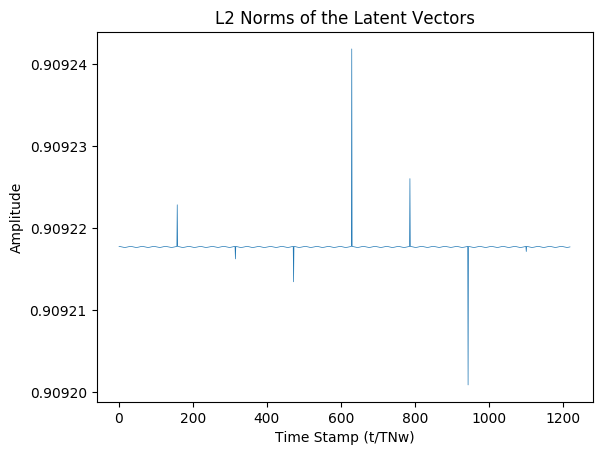

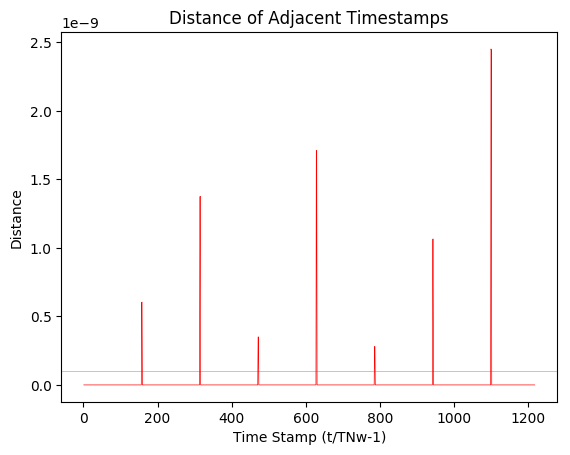

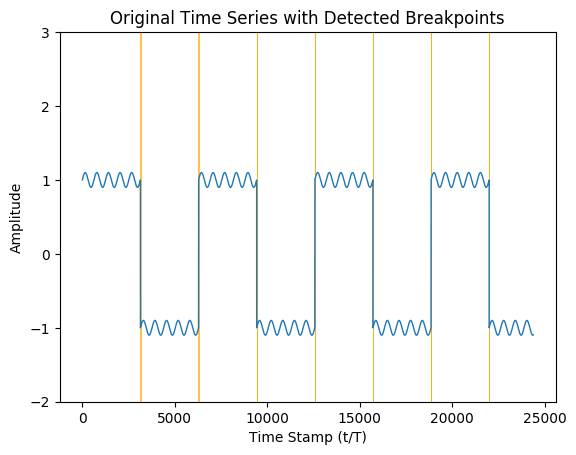

PyPlot.Figure(PyObject <Figure size 640x480 with 0 Axes>)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [10]:
# plot the L2 Norms of the Latent Vectors
l2(x) = sqrt.(x'*x)
lvec = Array{Float64}(TNw)
a = map(l2, run(ae.sess, ae.lvec))

for i=1:TNw lvec[i] = a[i][1] end
plot(linspace(1,TNw, TNw), lvec, linewidth=0.5)
title("L2 Norms of the Latent Vectors"); xlabel("Time Stamp (t/TNw)"); ylabel("Amplitude"); figure()

# plot the distances of the adjacent time stamps
x = linspace(1,TNw-1,TNw-1); _dist = run(ae.sess, ae.dist)
thresh = 0.04
max_value = maximum(_dist)

axhline(y=thresh*max_value, color="orange", linewidth=0.5)
plot(x,_dist, color="red", linewidth=0.5)
title("Distance of Adjacent Timestamps"); xlabel("Time Stamp (t/TNw-1)"); ylabel("Distance"); figure()

# plot detected breakpoints above the threshold against original data and add them to the list of breakpoints
breakpoints = []
enum_dist = Iterators.filter(x->x[2]>thresh*max_value,enumerate(_dist))
for val in enum_dist axvline(x=Nw*val[1], color="orange", linewidth=0.5); push!(breakpoints, Nw*val[1]) end

x = linspace(1,T,T)
for col = input_col
    y = f[1:T,col]
    plot(x,y, linewidth=1)
end
title("Original Time Series with Detected Breakpoints"); xlabel("Time Stamp (t/T)"); ylabel("Amplitude")
ylim(-2,3); figure()

In [11]:
breakpoints

14-element Array{Any,1}:
  3140
  3160
  6280
  6300
  9420
  9440
 12560
 12580
 15700
 15720
 18840
 18860
 21980
 22000